In [1]:
# pip install git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

from sklearn.model_selection import train_test_split

In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 5
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_path, grey_scale=False):
    img = tf.io.read_file(image_path)
    if image_path.endswith(".jpg"):
        img = tf.image.decode_jpeg(img)
    else:
        img = tf.image.decode_png(img)
        img = img[..., :3]

    if grey_scale and img.shape[-1] == 3:
        img = tf.image.rgb_to_grayscale(img)
    
    if img.shape[-1] == 1:
        img = tf.concat([img, img, img], axis=-1)

    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))

    img = tf.cast(img, tf.float32)

    return img

In [5]:
skeleton_data = []
animal_data = []

skel_folder_path = os.path.join('dataset/skeletons')
for img_file in os.listdir(skel_folder_path):
    img_path = os.path.join(skel_folder_path, img_file)
    img = load(img_path, True)
    skeleton_data.append(img)

folder_path = os.path.join('dataset/animal')
for img_file in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_file)
    img = load(img_path)
    animal_data.append(img)

# 75% train, 25% test
skel_train, skel_test, animl_train, animl_test = train_test_split(skeleton_data, animal_data, test_size=0.25, random_state=42)

2024-04-23 10:34:00.019092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-23 10:34:00.019103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-04-23 10:34:00.883140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-23 10:34:00.883153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-04-23 10:34:01.023825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-23 10:34:01.023837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [7]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [8]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [int(IMG_HEIGHT*1.2), int(IMG_WIDTH*1.2)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to IMG_HEIGHT x IMG_WIDTH x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
def preprocess_image_train(image, label=0):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label=1):
  image = normalize(image)
  return image

In [11]:
train_skel_ds = tf.data.Dataset.from_tensor_slices(skel_train)
train_animl_ds = tf.data.Dataset.from_tensor_slices(animl_train)
test_skel_ds = tf.data.Dataset.from_tensor_slices(skel_test)
test_animl_ds = tf.data.Dataset.from_tensor_slices(animl_test)

In [12]:
train_skel_ds = train_skel_ds.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_animl_ds = train_animl_ds.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_skel_ds = test_skel_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_animl_ds = test_animl_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
sample_skel = next(iter(train_skel_ds))
sample_animl = next(iter(train_animl_ds))

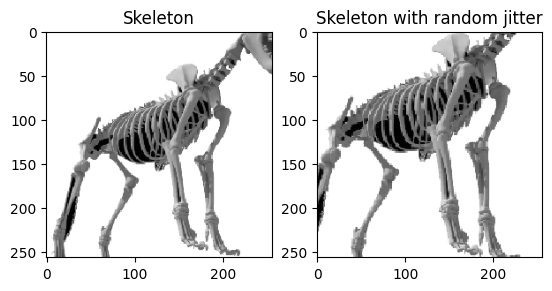

In [14]:
plt.subplot(121)
plt.title('Skeleton')
plt.imshow(sample_skel[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Skeleton with random jitter')
plt.imshow(random_jitter(sample_skel[0]) * 0.5 + 0.5)

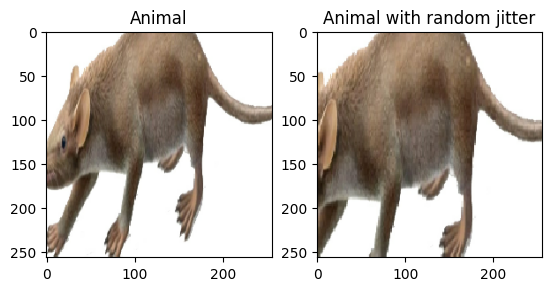

In [15]:
plt.subplot(121)
plt.title('Animal')
plt.imshow(sample_animl[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Animal with random jitter')
plt.imshow(random_jitter(sample_animl[0]) * 0.5 + 0.5)

In [16]:
OUTPUT_CHANNELS = 3
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


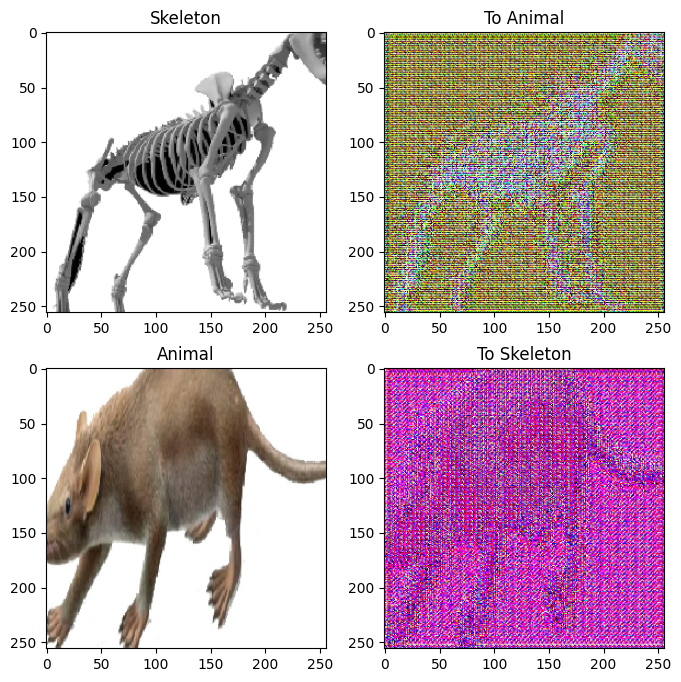

<Figure size 640x480 with 0 Axes>

In [17]:
to_skel = generator_g(sample_animl)
to_animl = generator_f(sample_skel)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_skel, to_animl, sample_animl, to_skel]
title = ['Skeleton', 'To Animal', 'Animal', 'To Skeleton']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()
plt.savefig('output.png')

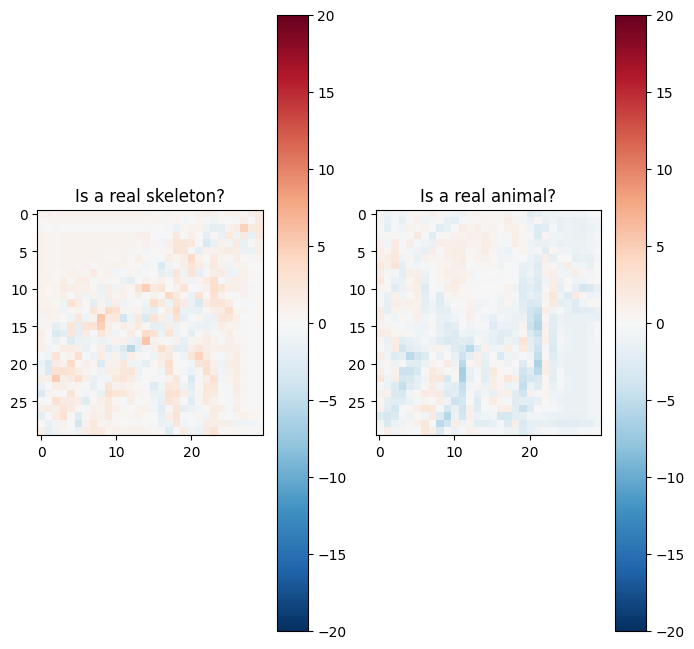

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.title('Is a real skeleton?')
plt.imshow(discriminator_y(sample_skel)[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('Is a real animal?')
plt.imshow(discriminator_x(sample_animl)[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()

In [19]:
# cycled image should be similar to input image, generated skel should look like the input skel
cycle_LAMBDA = 1
# giving animl to a skel-animl model should not change animl much since already in target domain
iden_LAMBDA = 10
# control discriminator loss
discr_LAMBDA = 1

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * discr_LAMBDA

In [21]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
    return cycle_LAMBDA * loss1

In [23]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return iden_LAMBDA * 0.5 * loss

In [24]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [26]:
EPOCHS = 5

def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [27]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

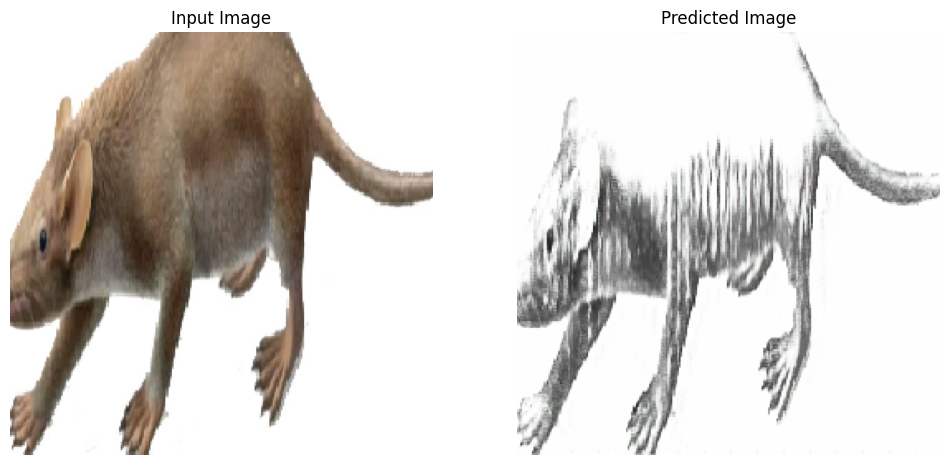

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-11
Time taken for epoch 5 is 307.5972647666931 sec



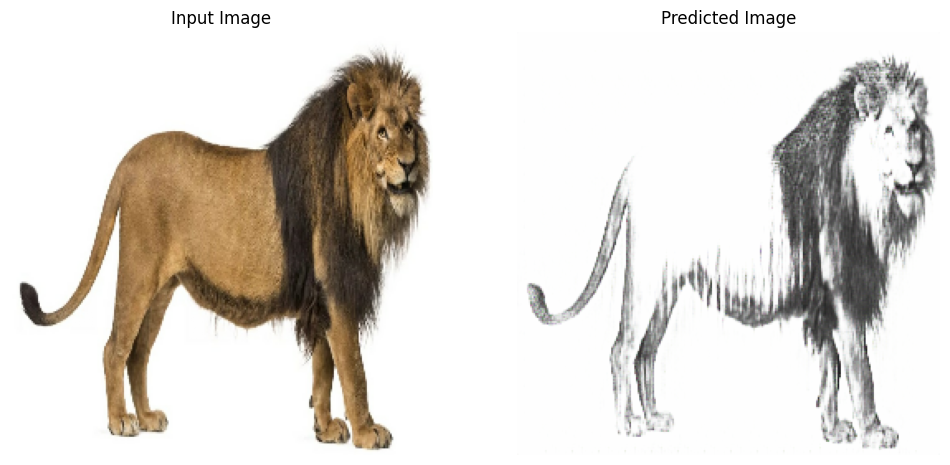

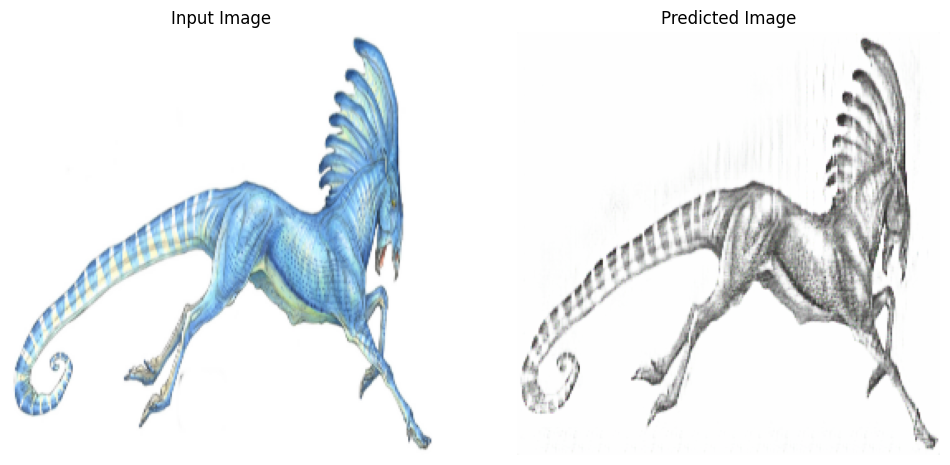

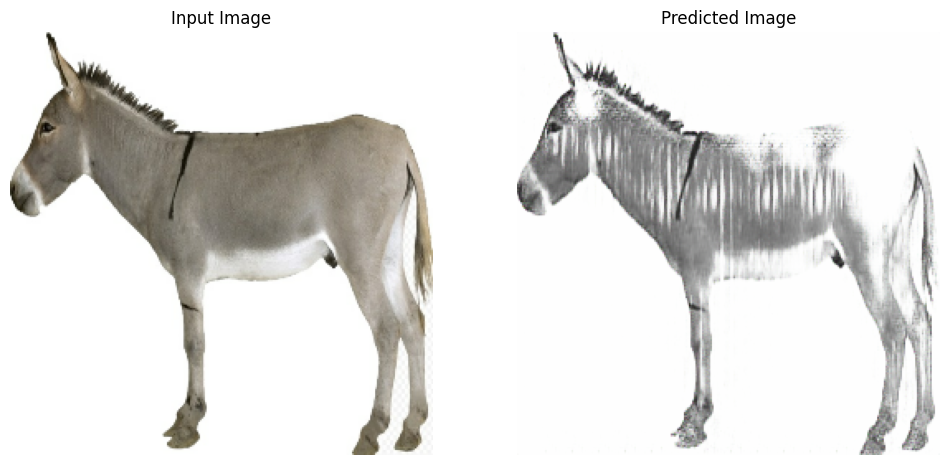

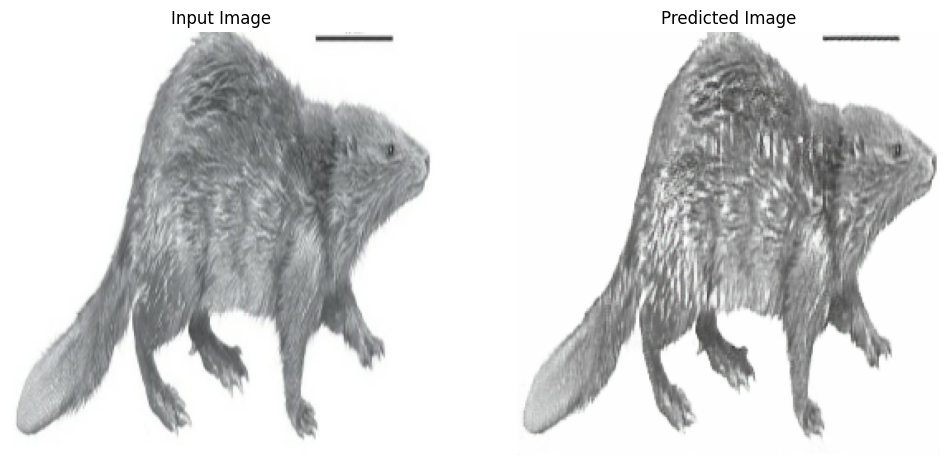

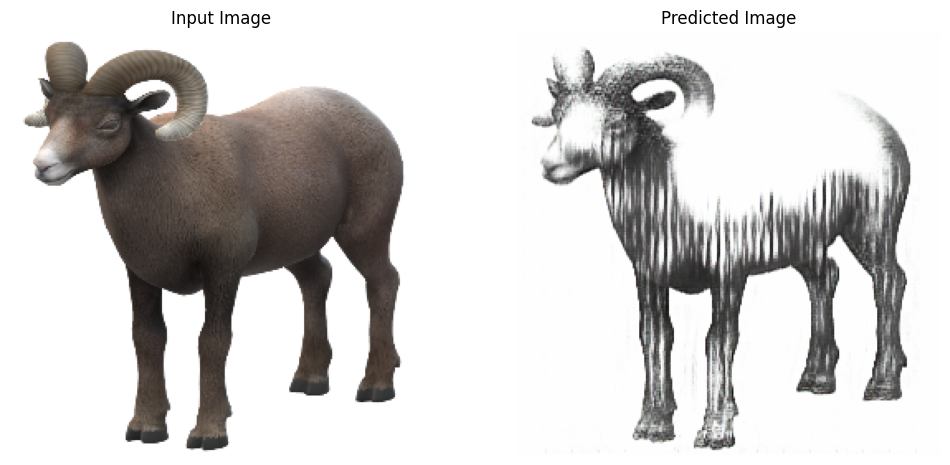

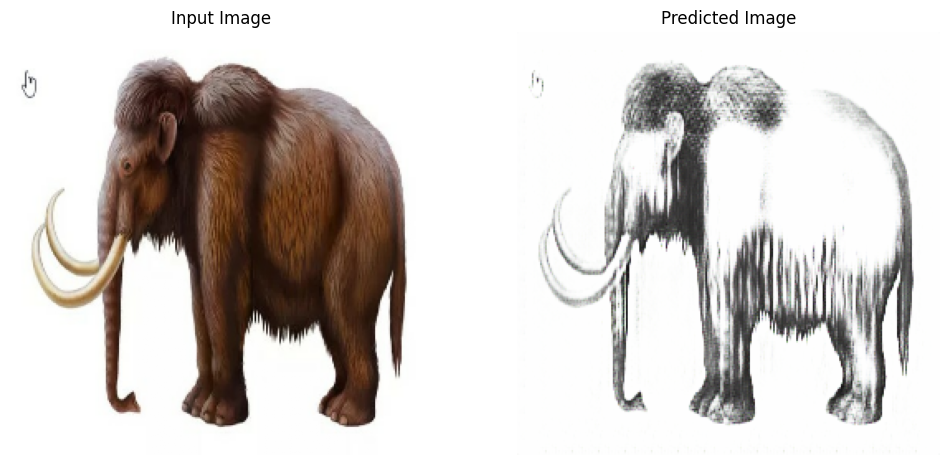

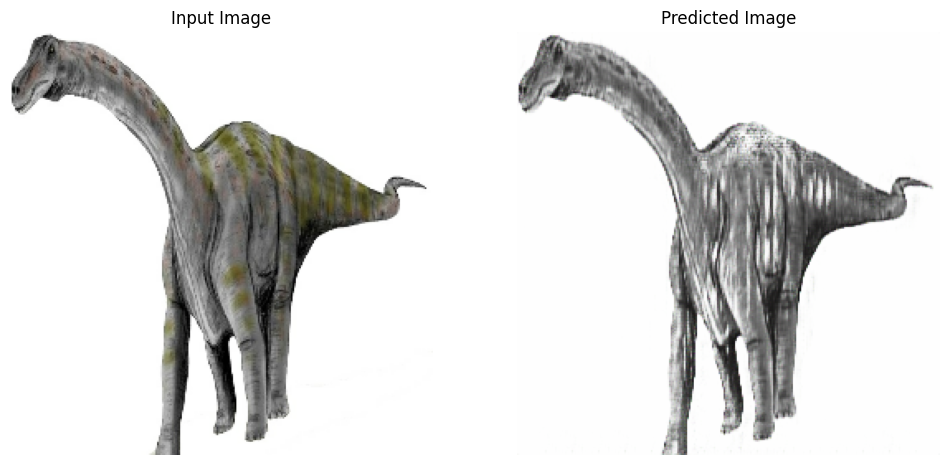

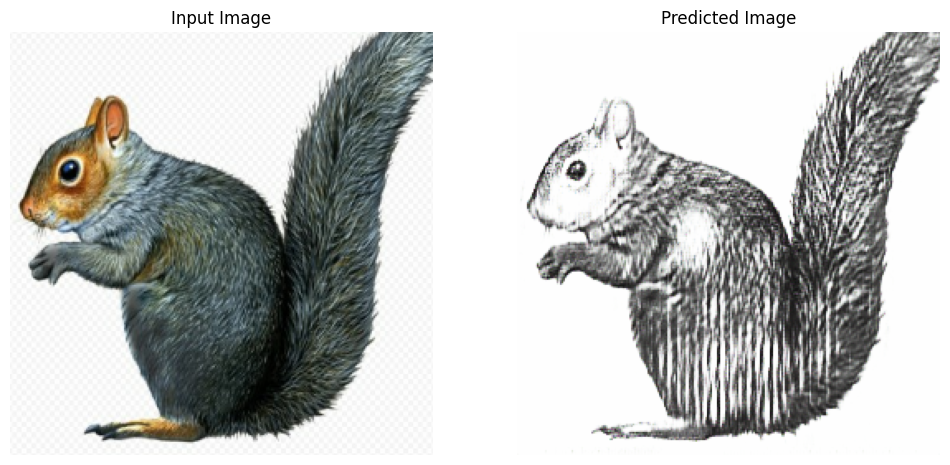

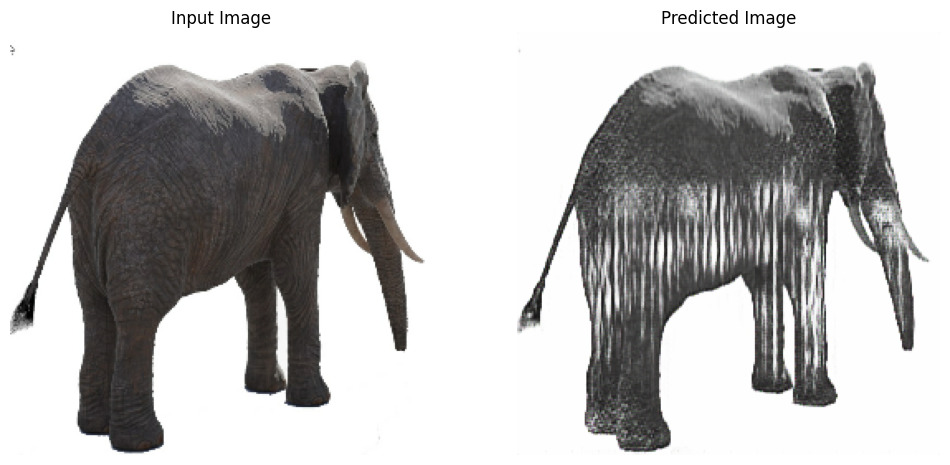

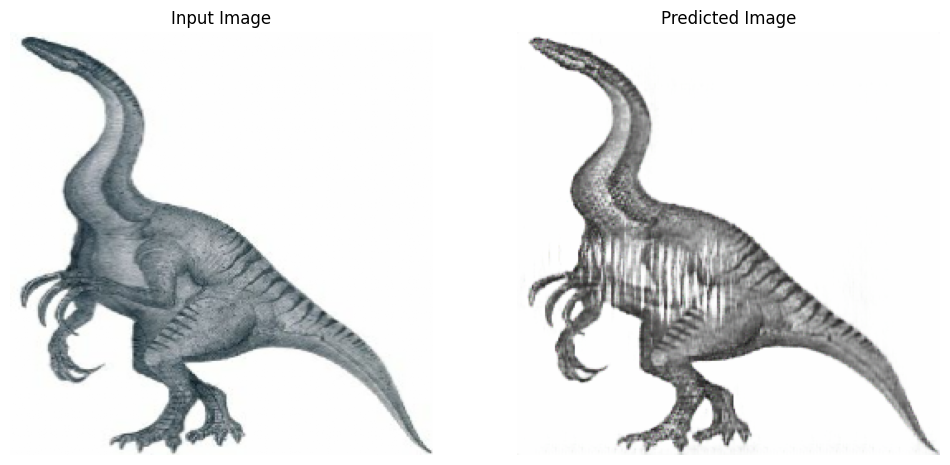

In [28]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_animl_ds, train_skel_ds)):
    train_step(image_y, image_x)  # Pass animal images as real_x and skeleton images as real_y
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_skel) so that the progress of the model
  # is clearly visible.
  generate_images(generator_f, sample_animl)  # Use generator_f for generating animals

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

for inp in test_animl_ds.take(10):
  generate_images(generator_f, inp)  # Use generator_f for generating animals


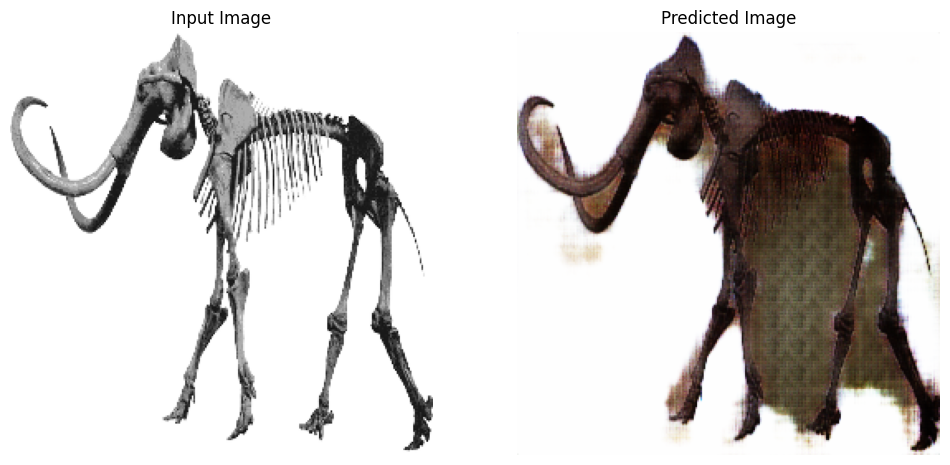

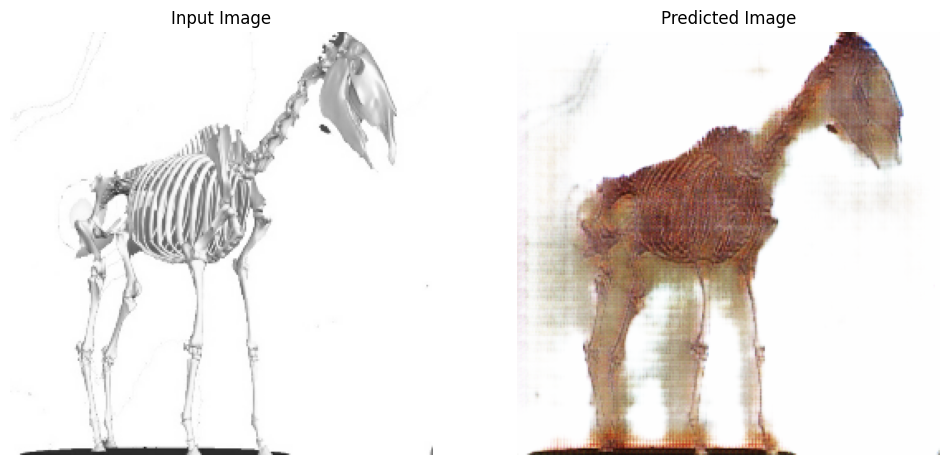

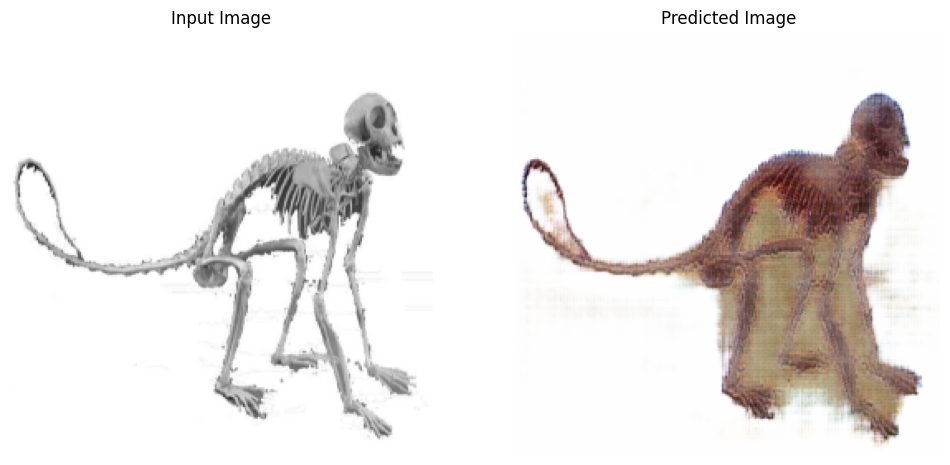

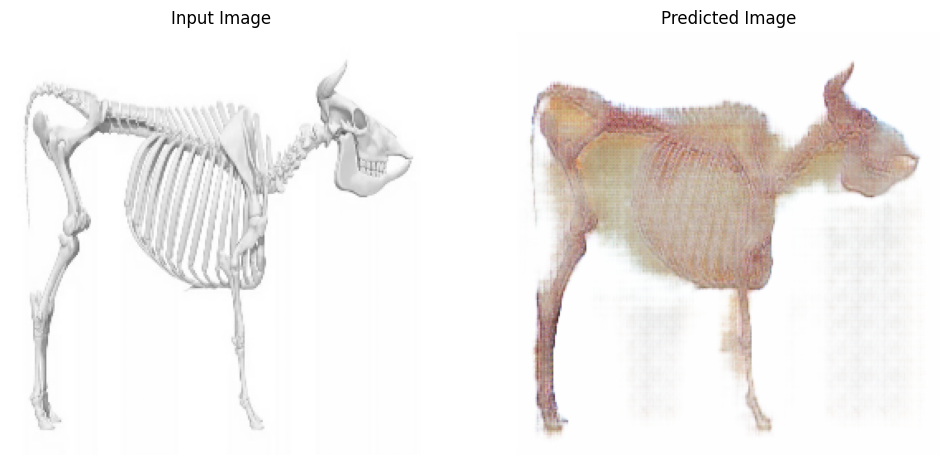

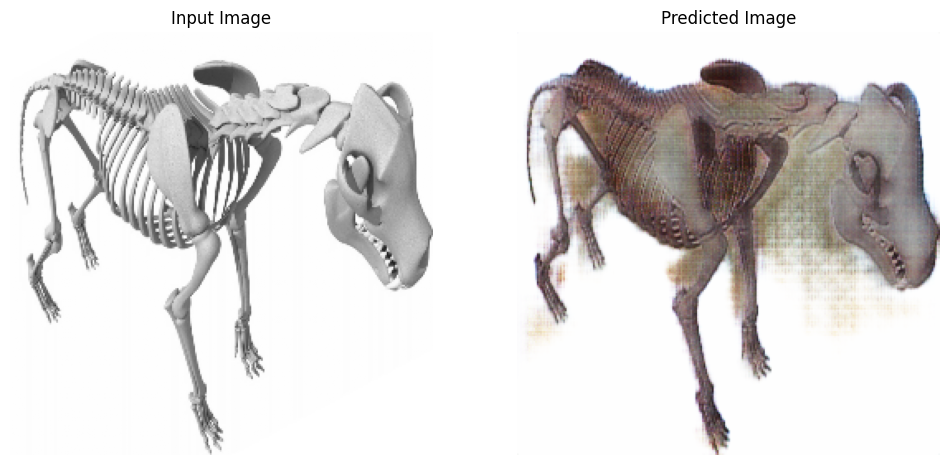

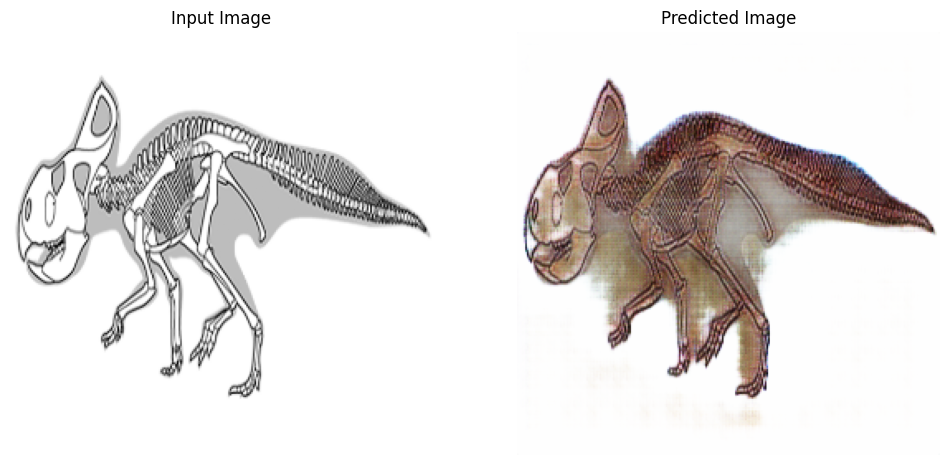

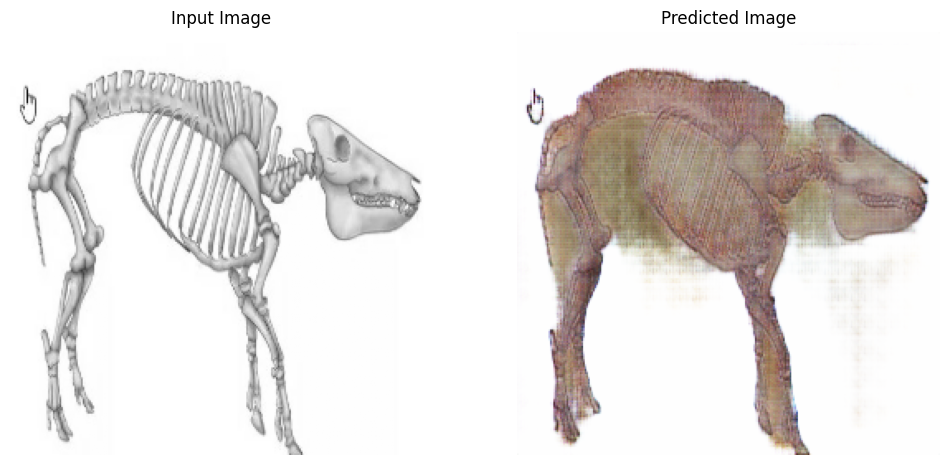

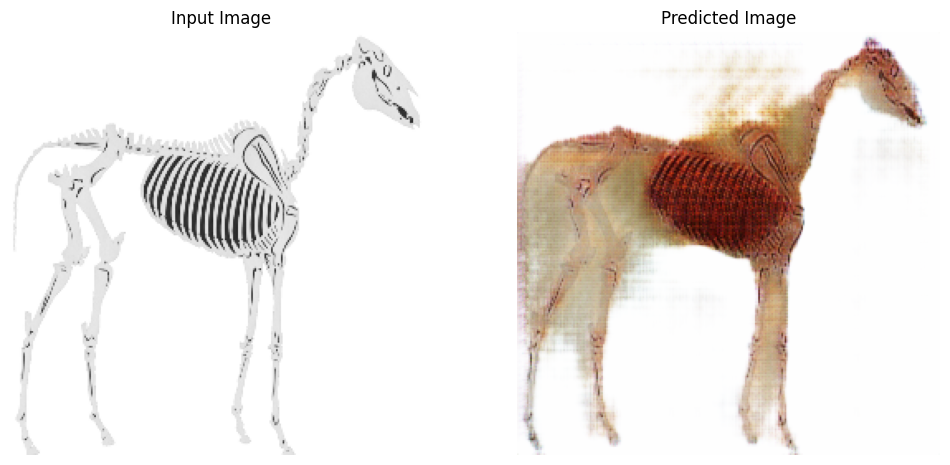

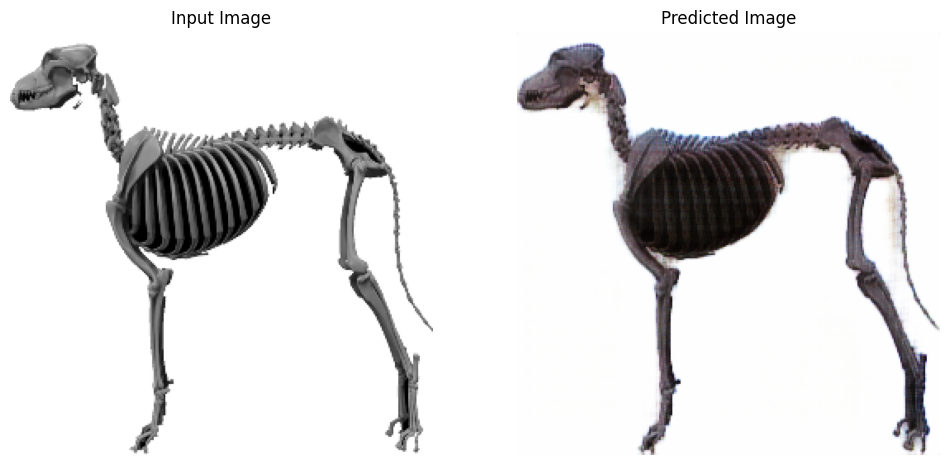

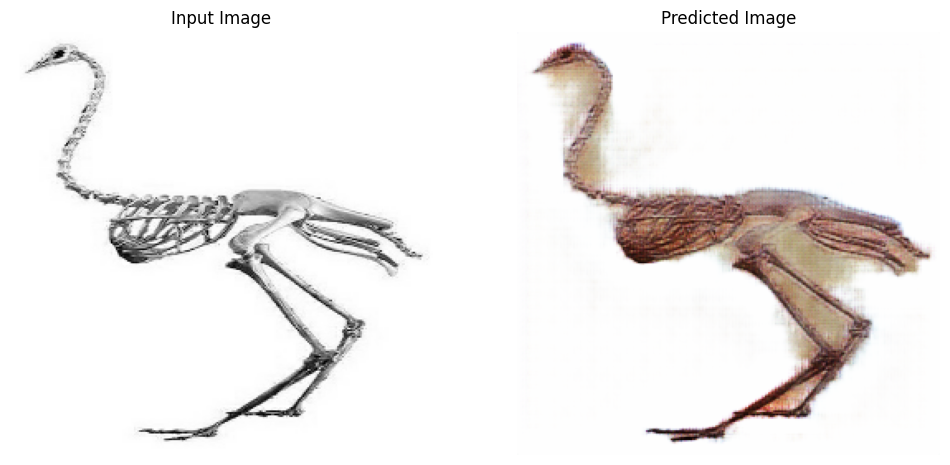

In [29]:
for inp in test_skel_ds.take(10):
  generate_images(generator_g, inp)